## Bike Sharing Demand Prediction_2 (Time Series)

### Data
Source: https://dacon.io/competitions/official/235837/data
#### Train/Test Dataset
* Columns:
    * `date_time`
    * `wind_direction`: direction of wind (degree)
    * `sky_condition`: 1 to 4 based on cloudiness (clear ~ cloudy)
    * `precipitation_form`: 0~4 based on form of rain 
    * `windspeed`: (m/s)
    * `humidity`: (%)
    * `low_temp`: (celcius)
    * `high_temp`: (celcius)
    * `Precipitation_Probability`: probability of raining
    * `number_of_rentals`: number of bike sharing demands, included in train data only
    

### Score Measures
* Evaluated with RMSE

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance

In [222]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [223]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [224]:
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459


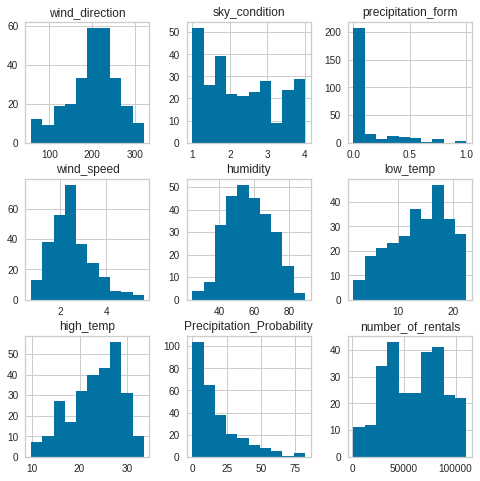

In [225]:
train.hist(figsize=(8,8))
plt.show()

In [226]:
train.describe()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,202.750967,2.288256,0.100963,2.480963,56.745491,13.795249,23.384733,16.878103,59574.978022
std,56.659232,0.961775,0.203193,0.884397,12.351268,5.107711,5.204605,16.643772,27659.575774
min,57.047000,1.000000,0.000000,0.753000,24.831000,1.938000,9.895000,0.000000,1037.000000
25%,171.541000,1.405000,0.000000,1.820000,47.196000,9.938000,19.842000,4.054000,36761.000000
50%,209.774000,2.167000,0.000000,2.411000,55.845000,14.375000,24.158000,12.162000,63032.000000
75%,238.412000,3.000000,0.088000,2.924000,66.419000,18.000000,27.526000,22.973000,81515.000000
max,321.622000,4.000000,1.000000,5.607000,88.885000,22.312000,33.421000,82.162000,110377.000000


In [227]:
train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])

In [228]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_time                  273 non-null    datetime64[ns]
 1   wind_direction             273 non-null    float64       
 2   sky_condition              273 non-null    float64       
 3   precipitation_form         273 non-null    float64       
 4   wind_speed                 273 non-null    float64       
 5   humidity                   273 non-null    float64       
 6   low_temp                   273 non-null    float64       
 7   high_temp                  273 non-null    float64       
 8   Precipitation_Probability  273 non-null    float64       
 9   number_of_rentals          273 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 21.5 KB


In [229]:
train.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

In [230]:
print(train.shape)
print(test.shape)

(273, 10)
(91, 9)


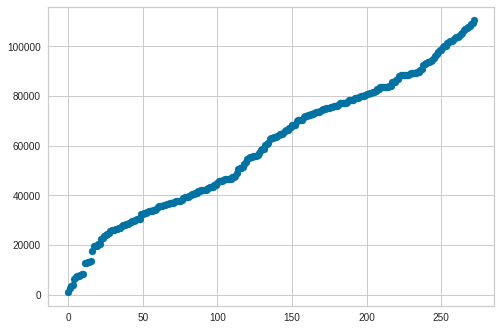

In [231]:
plt.scatter(range(train.shape[0]), np.sort(train['number_of_rentals'].values))

In [232]:
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['dayofweek'] = train['date_time'].dt.dayofweek # 월(0) 화(1) 수(2) 목(3) 금(4) 토(5) 일(6)
train['month_day'] = train['date_time'].dt.strftime('%m-%d')

test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day

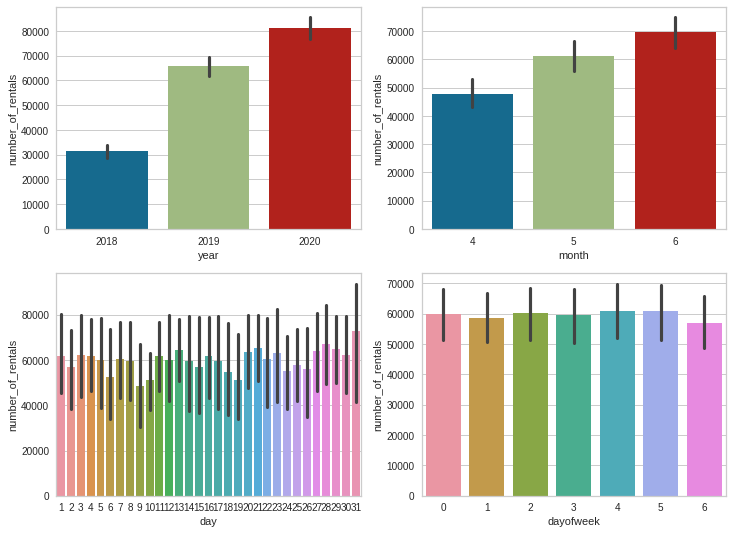

In [233]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

sns.barplot(data = train, x = 'year', y = 'number_of_rentals', ax = axes[0, 0])
sns.barplot(data = train, x = 'month', y = 'number_of_rentals', ax = axes[0, 1])
sns.barplot(data = train, x = 'day', y = 'number_of_rentals', ax = axes[1, 0])
sns.barplot(data = train, x = 'dayofweek', y = 'number_of_rentals', ax = axes[1, 1])
plt.show()

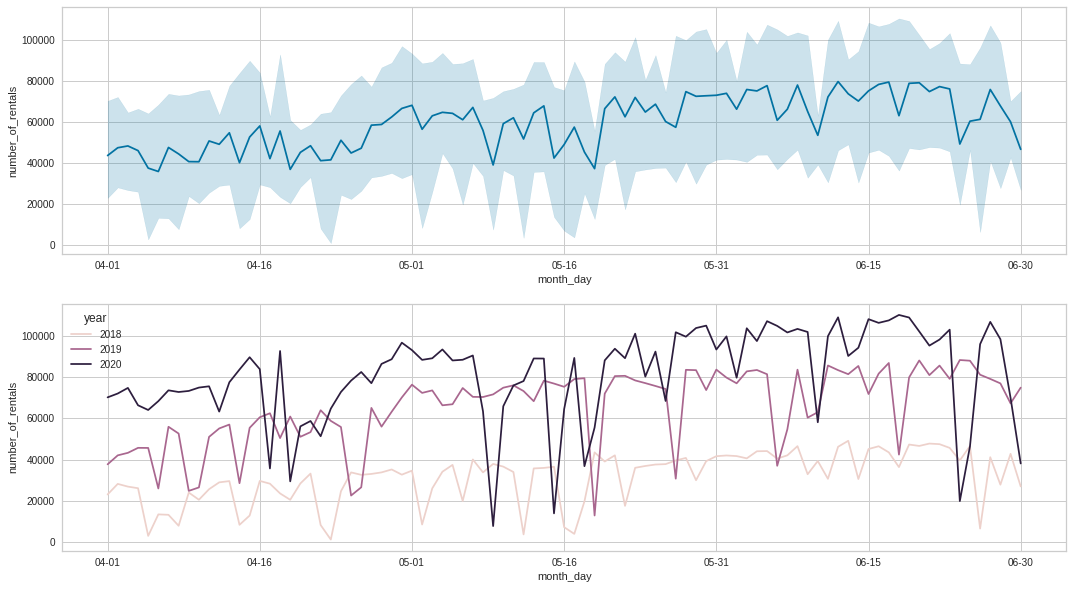

In [234]:
fig, axes = plt.subplots(nrows=2, figsize=(18, 10))

plt.setp(axes, xticks = [0, 15, 30, 45, 60, 75, 90])

sns.lineplot(data = train, x = 'month_day', y = 'number_of_rentals', ax = axes[0])
sns.lineplot(data = train, x = 'month_day', y = 'number_of_rentals', hue = 'year', ax = axes[1])

plt.show()

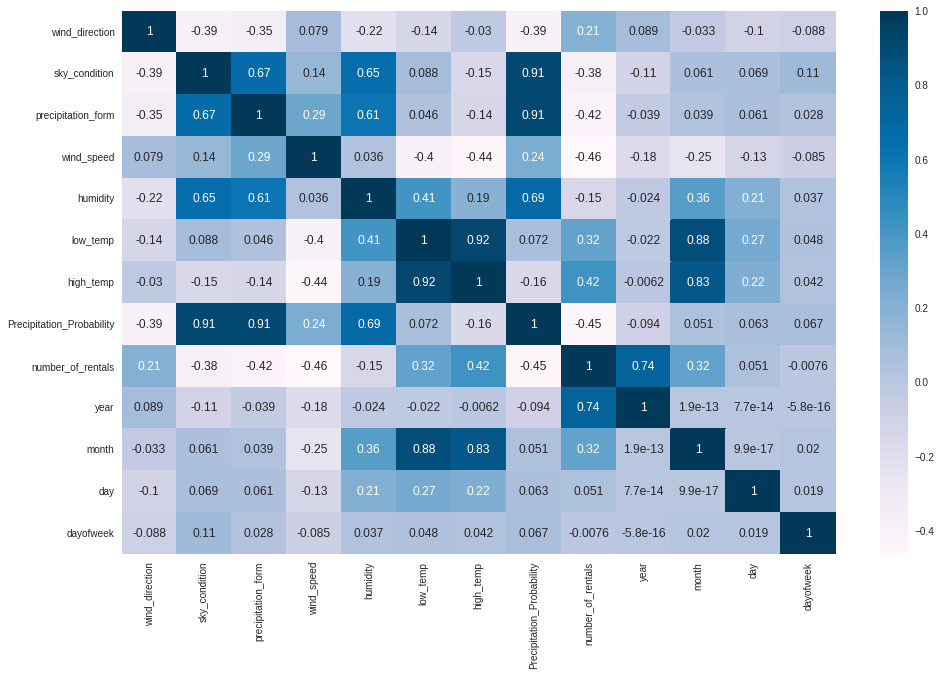

In [235]:
plt.figure(figsize = (16, 10))
colormap = plt.cm.PuBu
sns.heatmap(train.corr(), annot = True, cmap = colormap)
plt.show()

In [236]:
def is_weekend(t):
    if t.weekday() >= 5:
        return 1
    else:
        return 0

train['is_weekend'] = train.date_time.apply(lambda t : is_weekend(t))
test['is_weekend'] = test.date_time.apply(lambda t : is_weekend(t))

train['number_of_rentals'].groupby(train.is_weekend).agg('mean')

is_weekend
0    59809.512821
1    58988.641026
Name: number_of_rentals, dtype: float64

In [237]:
# t검정
import scipy.stats

weekend_0 = train[train['is_weekend']==0]['number_of_rentals'].values
weekend_1 = train[train['is_weekend']==1]['number_of_rentals'].values

scipy.stats.ttest_ind(weekend_0, weekend_1, equal_var=False)

Ttest_indResult(statistic=0.21688893338695225, pvalue=0.8286190941400347)

* Difference between the average of the two groups is statistically insignificant
* exclude precipitation probability, wind direction from prediction
* Seems like rentals go up with higher temperature

In [240]:
# create discomfort index variable
def get_discomfort(humid, min_t, max_t):
    temp = (min_t + max_t)/2
    humid = humid / 100
    discomfort = 1.8 * temp - 0.558 * (1 - humid) * (1.8*temp - 26) + 32
    return discomfort

In [241]:
train_dc = []
for i in range(len(train)):
    discomfort = get_discomfort(train.humidity[i], train.low_temp[i], train.high_temp[i])
    train_dc.append(discomfort)

test_dc = []
for i in range(len(test)):
    discomfort = get_discomfort(test.humidity[i], test.low_temp[i], test.high_temp[i])
    test_dc.append(discomfort)

train['discomfort'] = train_dc
test['discomfort'] = test_dc

In [242]:
# create coldness variable
train['cold_measure'] = train['low_temp'] / train['wind_speed']
test['cold_measure'] = test['low_temp'] / test['wind_speed']

# create wind chill temperature
train['temp_diff'] = train['high_temp'] - train['low_temp'] 
test['temp_diff'] = test['high_temp'] - test['low_temp']

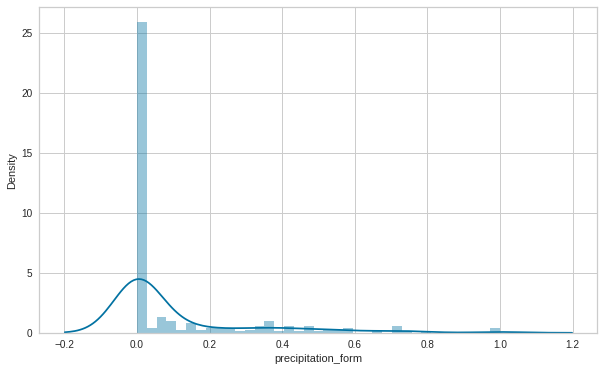

skewness: 2.3248757464391407
kurtosis: 5.137336383635427


In [243]:
col = 'precipitation_form'
fig, ax = plt.subplots(figsize = (10, 6))

sns.distplot(train[col])
plt.show()

print("skewness: {}".format(train[col].skew()))
print("kurtosis: {}".format(train[col].kurt()))

In [244]:
# transform precipitation form to either 0 (not raining) or 1 (raining)
train['precipitation_form'] = train['precipitation_form'].apply(lambda x: 1 if x>=1 else 0)
test['precipitation_form'] = test['precipitation_form'].apply(lambda x: 1 if x>=1 else 0)

#train['precipitation_form'] = train['precipitation_form'].astype('category')
#test['precipitation_form'] = test['precipitation_form'].astype('category')

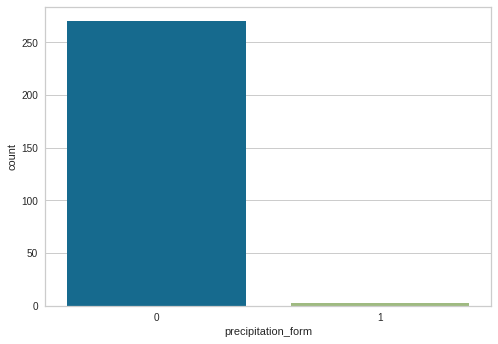

In [245]:
sns.countplot(data = train, x = 'precipitation_form')

In [246]:
train.drop(['wind_direction', 'Precipitation_Probability', 'date_time', 'month_day', 'dayofweek', 'month', 'is_weekend'], axis=1, inplace = True)
test.drop(['wind_direction', 'Precipitation_Probability', 'date_time', 'month', 'is_weekend'], axis=1, inplace = True)

In [247]:
train

,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,number_of_rentals,year,day,discomfort,cold_measure,temp_diff
0,4.000,0,3.050,75.000,12.600,21.000,22994,2018,1,61.648520,4.131148,8.400
1,2.950,0,3.278,69.833,12.812,19.000,28139,2018,2,60.187953,3.908481,6.188
2,2.911,0,2.690,74.879,10.312,15.316,26817,2018,3,55.476586,3.833457,5.004
3,3.692,0,3.138,71.849,8.312,12.368,26034,2018,4,51.772526,2.648821,4.056
4,4.000,0,3.186,73.784,5.875,10.421,2833,2018,5,48.324339,1.844005,4.546
...,...,...,...,...,...,...,...,...,...,...,...,...
268,3.980,0,2.271,78.378,20.500,27.526,96150,2020,26,73.145384,9.026860,7.026
269,2.865,0,1.794,78.412,20.812,28.842,107001,2020,27,74.437352,11.600892,8.030
270,1.730,0,1.820,72.736,21.000,29.053,98568,2020,28,74.149914,11.538462,8.053
271,2.257,0,2.043,70.473,19.625,26.000,70053,2020,29,70.580793,9.605972,6.375


## Modeling

### XGBoost

In [248]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance

X = train.drop('number_of_rentals', axis = 1)
y = train['number_of_rentals']

In [249]:
reg = LinearRegression()
reg.fit(X, y)

X_pred = reg.predict(X)
mean_squared_error(y, X_pred)**0.5

11654.716717262332

In [257]:
reg = XGBRegressor(objective='reg:squarederror', max_depth = 7, n_estimators = 2000, random_state = 42, learning_rate = 0.05)
reg.fit(X, y)
pred = reg.predict(test)

# X값을 토대로 다시 정확도 확인
X_pred = reg.predict(X)
mean_squared_error(y, X_pred)**0.5

0.07431767498824114

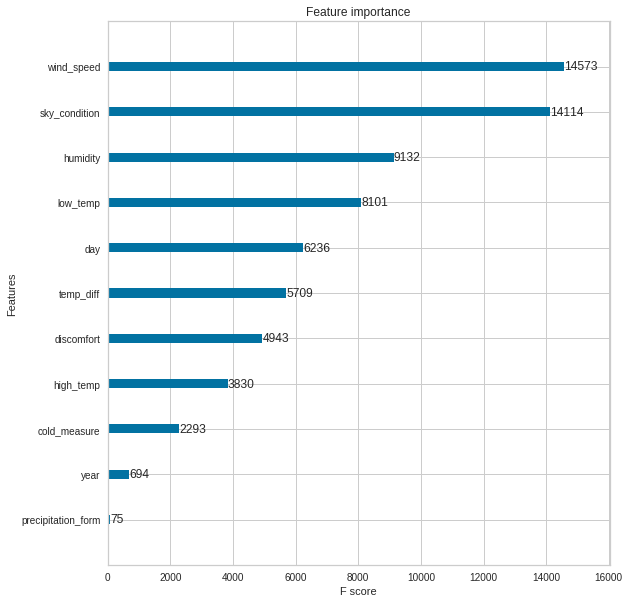

In [254]:
fig, ax = plt.subplots(figsize=(9,10))
plot_importance(reg, ax=ax)

In [263]:
pred = reg.predict(test)
t = pd.read_csv('test.csv')
submission = pd.DataFrame()
submission['datetime'] = t['date_time']
submission['number_of_rentals'] = pred
submission

,datetime,number_of_rentals
0,2021-04-01,72778.656250
1,2021-04-02,49692.062500
2,2021-04-03,27334.451172
3,2021-04-04,44563.519531
4,2021-04-05,68527.140625
...,...,...
86,2021-06-26,93421.796875
87,2021-06-27,105206.554688
88,2021-06-28,91159.601562
89,2021-06-29,86077.570312


### Pycaret

In [153]:
#!pip install pycaret

In [152]:
#!pip uninstall scikit-learn -y
#!pip install scikit-learn==0.23.2

In [251]:
from pycaret.regression import *
model = setup(train, target = 'number_of_rentals', 
              fold_shuffle=True,
              fold=15, 
              session_id=530,
              remove_multicollinearity = True,
              normalize= True,
              n_jobs = -1,
              silent = True,
              combine_rare_levels = True,
              ignore_low_variance = True ) 

,Description,Value
0,session_id,530
1,Target,number_of_rentals
2,Original Data,"(273, 12)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(191, 10)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='number_of_rentals',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('dummy', Dummify(target='number_of_rentals')),
                ('fix_perfect', Remove_100(target='number_of_rentals')),
                ('clean_names', Clean

In [252]:
top5_model = compare_models(round=4, n_select = 5, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,8147.1699,1.418673e+08,11595.0518,0.7763,0.2997,0.2293,0.0687
et,Extra Trees Regressor,8018.0936,1.422392e+08,11651.6297,0.7710,0.3092,0.2648,0.1687
huber,Huber Regressor,7913.6955,1.632678e+08,11807.5296,0.7581,0.3422,0.2709,0.0207
lightgbm,Light Gradient Boosting Machine,8808.7643,1.463192e+08,11831.7395,0.7637,0.2999,0.2515,0.0940
llar,Lasso Least Angle Regression,8847.9251,1.532894e+08,11890.1701,0.7657,0.3519,0.2660,0.0133
lasso,Lasso Regression,8851.3773,1.535527e+08,11900.5418,0.7653,0.3522,0.2663,0.0140
lr,Linear Regression,8851.5790,1.535732e+08,11901.3104,0.7653,0.3522,0.2663,0.2500
ridge,Ridge Regression,8902.5375,1.534686e+08,11909.4005,0.7650,0.3389,0.2653,0.0113
par,Passive Aggressive Regressor,8351.0517,1.636625e+08,11912.2543,0.7551,0.3282,0.2840,0.0253
br,Bayesian Ridge,8909.1776,1.536408e+08,11916.1571,0.7648,0.3396,0.2656,0.0133


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
      

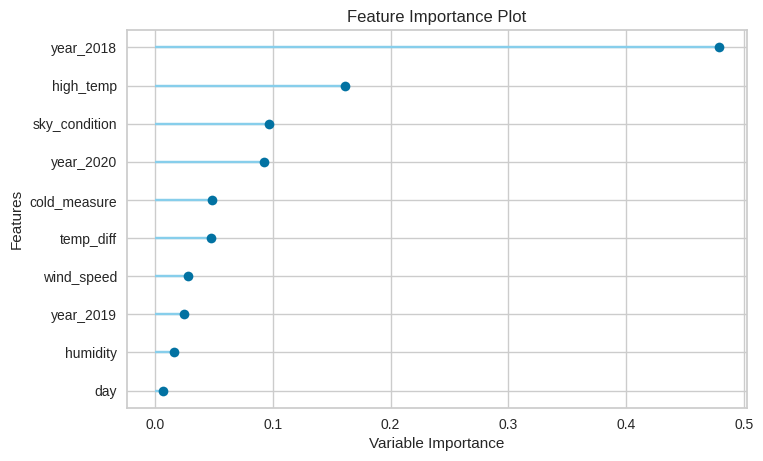

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [253]:
model = create_model('gbr')
plot_model(model, plot = 'feature')

In [256]:
temp = [top5_model[0], top5_model[1]]
blender = blend_models(temp, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5988.7767,6.971575e+07,8349.5958,0.9095,0.3060,0.1300
1,10274.7044,2.191943e+08,14805.2121,0.7881,0.3068,0.2345
2,9035.6037,1.688398e+08,12993.8366,0.7170,0.4817,0.3483
3,7491.1216,2.021382e+08,14217.5314,0.7042,0.4636,0.3994
4,8244.4904,1.206227e+08,10982.8375,0.8252,0.4963,0.4845
5,5550.5432,9.284081e+07,9635.3935,0.8492,0.2075,0.1308
6,7338.6174,1.548252e+08,12442.8782,0.6588,0.1735,0.0984
7,5341.0483,6.429871e+07,8018.6476,0.9075,0.1050,0.0782
8,7111.6500,1.124927e+08,10606.2560,0.8961,0.3049,0.2334


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 4
INFO:logs:VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
     

In [258]:
prediction = predict_model(blender, data=test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                               

In [265]:
submission2 = pd.DataFrame()
submission2['datetime'] = t['date_time']
submission2['number_of_rentals'] = prediction['Label']
submission2

,datetime,number_of_rentals
0,2021-04-01,54393.163937
1,2021-04-02,33003.101373
2,2021-04-03,34634.405798
3,2021-04-04,34223.464261
4,2021-04-05,60588.456512
...,...,...
86,2021-06-26,71318.989924
87,2021-06-27,80694.291954
88,2021-06-28,77007.024632
89,2021-06-29,76619.101851


* score (validation): 0.3
* Takeaways
    * pycaret is useful to compare score values across different models
    * considering the datetime data may lead to better predictions
    